This notebook is an attempt at the [Kaggle Two Sigma Connect Rental Listing Inquiries Competition](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data). 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

train_df = pd.read_json('train.json', orient='columns')

y_cols_map = {'high':0, 'medium':1, 'low':2 }
train_y = np.array(train_df['interest_level'].apply(lambda x: y_cols_map[x]))
train_df["interest_level"] = train_y

test_df = pd.read_json('test.json', orient='columns')

# merge the training and test set
merged_df = train_df.append(test_df)

# feature creation
merged_df["num_pics"] = merged_df["photos"].apply(len)
merged_df["created"] = pd.to_datetime(merged_df["created"])
merged_df["c_year"] = merged_df["created"].dt.year
merged_df["c_month"] = merged_df["created"].dt.month
merged_df["c_day"] = merged_df["created"].dt.day
merged_df["c_hour"] = merged_df["created"].dt.hour
merged_df["descr_word_count"] = merged_df["description"].apply(lambda x: len(x.split(" ")))
merged_df["has_email"] = 0
merged_df["has_email"].ix[merged_df['description'].str.contains('@')] = 1 #throws a warning (ignore)
merged_df["features_count"] = merged_df["features"].apply(len)

trainSize = len(train_df)
train_df = merged_df[:trainSize]
test_df = merged_df[trainSize:]

# the features we are using to train on (numerical only)
features = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'num_pics', 'c_year', 'c_month', 'c_day', 
            'c_hour', 'descr_word_count', 'has_email', 'features_count', 'price']


# split the training dataset to a new training and vaidation set
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df['interest_level'], test_size=0.3)

print("Size in\n\ttraining: ", len(X_train), "\n\tvalidation:", len(X_valid), "\n\ttest:", len(test_df))

Size in
	training:  34546 
	validation: 14806 
	test: 74659


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Train a Random Forest

In [2]:
# Train and calculate log loss on validation set
rf = RandomForestClassifier(n_estimators=1000,max_depth=10)
fitted_rf = rf.fit(X=X_train, y=y_train)
y_pred = rf.predict_proba(X_valid)

lloss = log_loss(y_valid, y_pred)
print("RF log loss - validation set:", lloss)

# predict on the test data set
rf_predicted_test_y = rf.predict_proba(test_df[features])

RF log loss - validation set: 0.65145517519


Take a look at the importance of the features included

[ 0.02840119  0.07594586  0.0864459   0.08233904  0.08740579  0.
  0.01113442  0.03504028  0.14815469  0.07245668  0.02757399  0.05771863
  0.28738352]


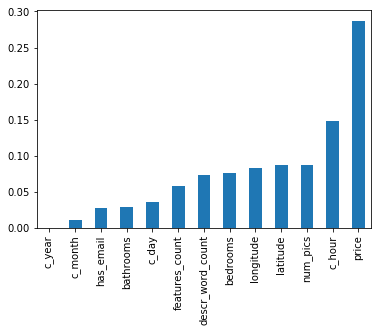

In [3]:
pd.Series(index=features,data=rf.feature_importances_).sort_values().plot(kind='bar')

print(rf.feature_importances_)


Train a Gradient Boosting Model

In [4]:
gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)
y_pred = gbm.predict_proba(X_valid)

lloss = log_loss(y_valid, y_pred)
print("GBM log loss - validation set:", lloss)

gbm_predicted_test_y = gbm.predict_proba(test_df[features])

GBM log loss - validation set: 0.63027941252


Take the average predictions of each model for the final prediction

In [5]:
mean_y = (rf_predicted_test_y + gbm_predicted_test_y) / 2

Create the submission CSV

In [6]:
# create the dataframe in the contest required format and save as csv
submit_df = pd.DataFrame()
submit_df["listing_id"] = test_df['listing_id']

for label in ['high','medium','low']:
    submit_df[label] = mean_y[:, y_cols_map[label]]

submit_df.to_csv("submission.csv", index=False)